In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tellurium as te 
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

## Figure Idea 1
- Establish that infection has oscilating behavior, if no medication given
- Establish that erythropoesis works by resuce if 10% reduction of erythrocytes
- medication kills infection

In [13]:
def simulate_model(model_path: str = '/home/nexia/PhD/pth_model/LCT_model/LCT_OIE.ant', 
                   infection_pars: dict = {}, 
                   ss_duration:float=4.,pre_t:float=3.0, simulation_end:float=50.0, 
                   bool_med= True, bool_set_pars=False,
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]','[P]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] + [f'[oiE_{i}]' for i in range(1, 13)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    model = te.loada(model_path)
   
    if bool_set_pars:
        for p in infection_pars:
            model.setValue(p, infection_pars[p])
    # ss simulation
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    model.M = 40e3

    for p in infection_pars:
        model.setValue(p, infection_pars[p])

    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df 

def pretty_plot(results, axs=None, c=None):
    species_to_analyze = OrderedDict({
        'parasitemia' : ['parasitemia (%)', 1],
        #'[M]' : ['M (1e4/µl)', 1e4],
        '[iE]': ['iE (1e4/µl)', 1e4],
        'oiE': ['oiE (1e4/µl)', 1e4],
        '[E]': ['E (1e4/µl)', 1e4],
        '[R]': ['R (1e4/µl)', 1e4],
        #'[P]': ['P (1e0/µl)', 1e0],
        #'J_P_birth':['J_P_birth',1e0],
        'Hb': ['Hb (g/dl)', 1],
        'Hkt': ['Hkt', 1],
        'RPI': ['RPI', 1],
        'LDH': ['LDH (U/l)',1],
    })
    if axs.dtype==None:
        # Durchführung des Parameter-Scans und Erstellung der Plots
        cols = 3
        rows = int(np.ceil(len(species_to_analyze)/cols))   

        fig, axs = plt.subplots(rows,cols, figsize=(20,15), sharex=True)
        fig.subplots_adjust(hspace=0.38, wspace= 0.42)
    size_of_font = 24

    # Farbübergang
    if c ==None:
        cmap = plt.colormaps.get_cmap('Reds')
        c=cmap(0.8)

    for j, specie in enumerate (species_to_analyze.keys()):

        row = j //3
        col = j % 3


        axs[row, col].plot(results['time'], results[specie]/species_to_analyze[specie][1],
                            color=c)
        axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
        axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
        axs[row, col].tick_params(labelsize=size_of_font)

        axs[row, col].axvspan(0, 0.3, facecolor='gainsboro', alpha=1, linewidth=2) #, label='ACT Administration')
        axs[row, col].axvspan(1, 1.3, facecolor='gainsboro', alpha=1, linewidth=2)
        axs[row, col].axvspan(2, 2.3, facecolor='gainsboro', alpha=1, linewidth=2)

        axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)))   
        
        
    handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-1, -1].legend(handles, labels, loc='lower left', 
                        bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)


    #plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    #plt.show()
    return axs
def convert_bounds_to_logscale(bounds):
    """
    converts bounds for parameters from linear scale to log10 scale. If a bound is 0, it's replaced with 1e-8 to avoid infinity values in log scale.
    Input and output: Ordered dictionaries
    """
    log_bounds = OrderedDict({})

    for param, bound in bounds.items():
        if bound[0] == 0:
            bound = (bound[1]*1e-3, bound[1])
        log_bounds[param] = (np.log10(bound[0]), np.log10(bound[1]))

    return log_bounds

### Plot model with and without bystander haemolysis

In [14]:
k_iE_pit_frac = 0.5

# simulate no by-stander haemolysis
#infect_pars = {'k_E_infect': k_infect, 's_BH': 0, 'k_iE_pit_frac': k_iE_pit_frac}
update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 4.429542038768788,
        'k_M_death': 48,
        's_BH': 0,                              # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
no_bh_res = simulate_model(infection_pars=infect_pars)

# simulate by-stander haemolysis
#infect_pars = {'k_E_infect': k_infect, 's_BH': 1.361151210723645e-06,'k_iE_pit_frac': k_iE_pit_frac}#{'k_E_infect': k_infect, 's_BH': 1e-6 }
update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 4.429542038768788,
        'k_M_death': 48,
        's_BH': 1.361151210723645e-06,          # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
bh_res = simulate_model(infection_pars=infect_pars) 

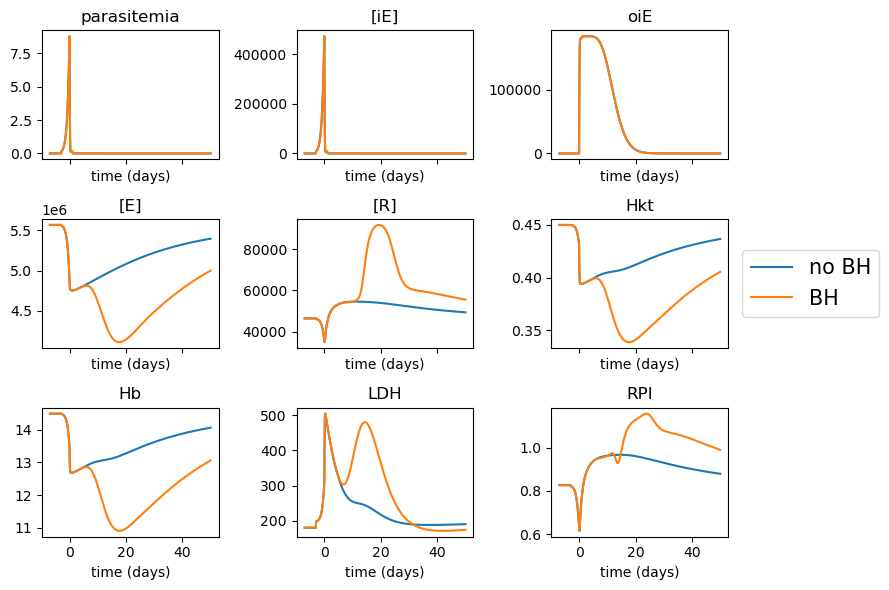

In [15]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE',
               #'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI',
               #'[M]','J_P_birth', 'J_P_death'
               ]
# 'rpi_step_func'
n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, sharex=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    ax[row, col].plot(no_bh_res['time'], no_bh_res[obs], label='no BH')
    ax[row, col].plot(bh_res['time'], bh_res[obs], label='BH')
    ax[row, col].set_title(obs)
    ax[row, col].set_xlabel('time (days)')
    #ax[row, col].legend()
handles, labels = ax[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


ax[1, -1].legend(handles, labels, loc='center left', 
                  bbox_to_anchor=(1.02, 0.5), fontsize=15
                  ) #bbox (nach rechts-links, oben-unten, negativ yes)
plt.tight_layout()  
plt.show()

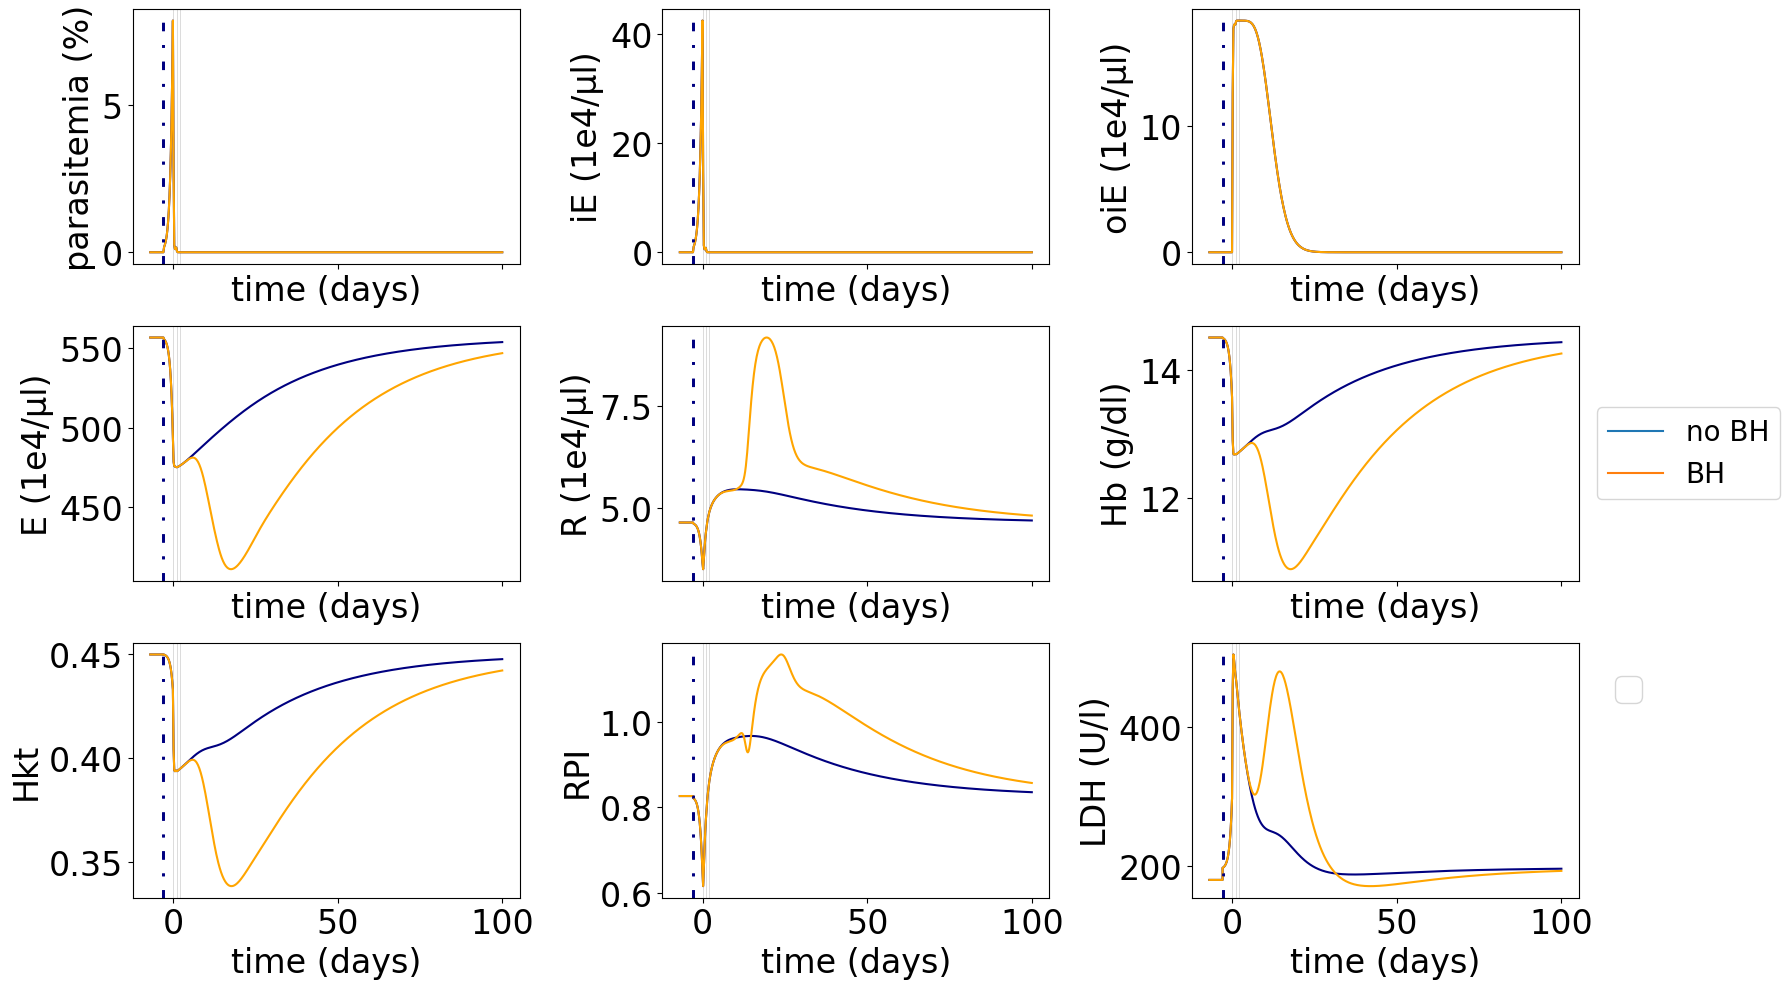

In [16]:

# simulate no by-stander haemolysis
update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 4.429542038768788,
        'k_M_death': 48,
        's_BH': 1.361151210723645e-06,          # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
pre_t = 3.0

#no_meds = simulate_model(infection_pars=infect_pars, bool_med=True, simulation_end= 40)

cols = 3
rows = 3  
fig, axs_all = plt.subplots(rows,cols, figsize=(18,10), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
#pretty_plot(no_meds, axs_all)
color= ['navy', 'orange']

for i,k in enumerate([0,1.361151210723645e-06]):
        update_parameters['s_BH']=k
        no_meds = simulate_model(infection_pars=infect_pars,simulation_end= 100)
        pretty_plot(no_meds, axs_all, c=color[i])
handles, labels = ax[1, -1].get_legend_handles_labels()  # Legend Box outsides Subplots
axs_all[1, -1].legend(handles,['no BH','BH'], loc='center left', 
                  bbox_to_anchor=(1.01, 0.5), fontsize=20
                  ) #bbox (nach rechts-links, oben-unten, negativ yes)
fig.tight_layout()
fig.show()

In [17]:
axs_all.flatten()[0]

<Axes: xlabel='time (days)', ylabel='parasitemia (%)'>

### Plot for damped oscilation of model
- [x] find parameter values for oscilation
    - parameter values are not the ones as used in model before
    - tropism = 1, if  > 2 it damps the oscilation to near none
        - parameter scan of interest
    - higher k_M_death = 96 or could lower k_E_infect to make oscilation possible

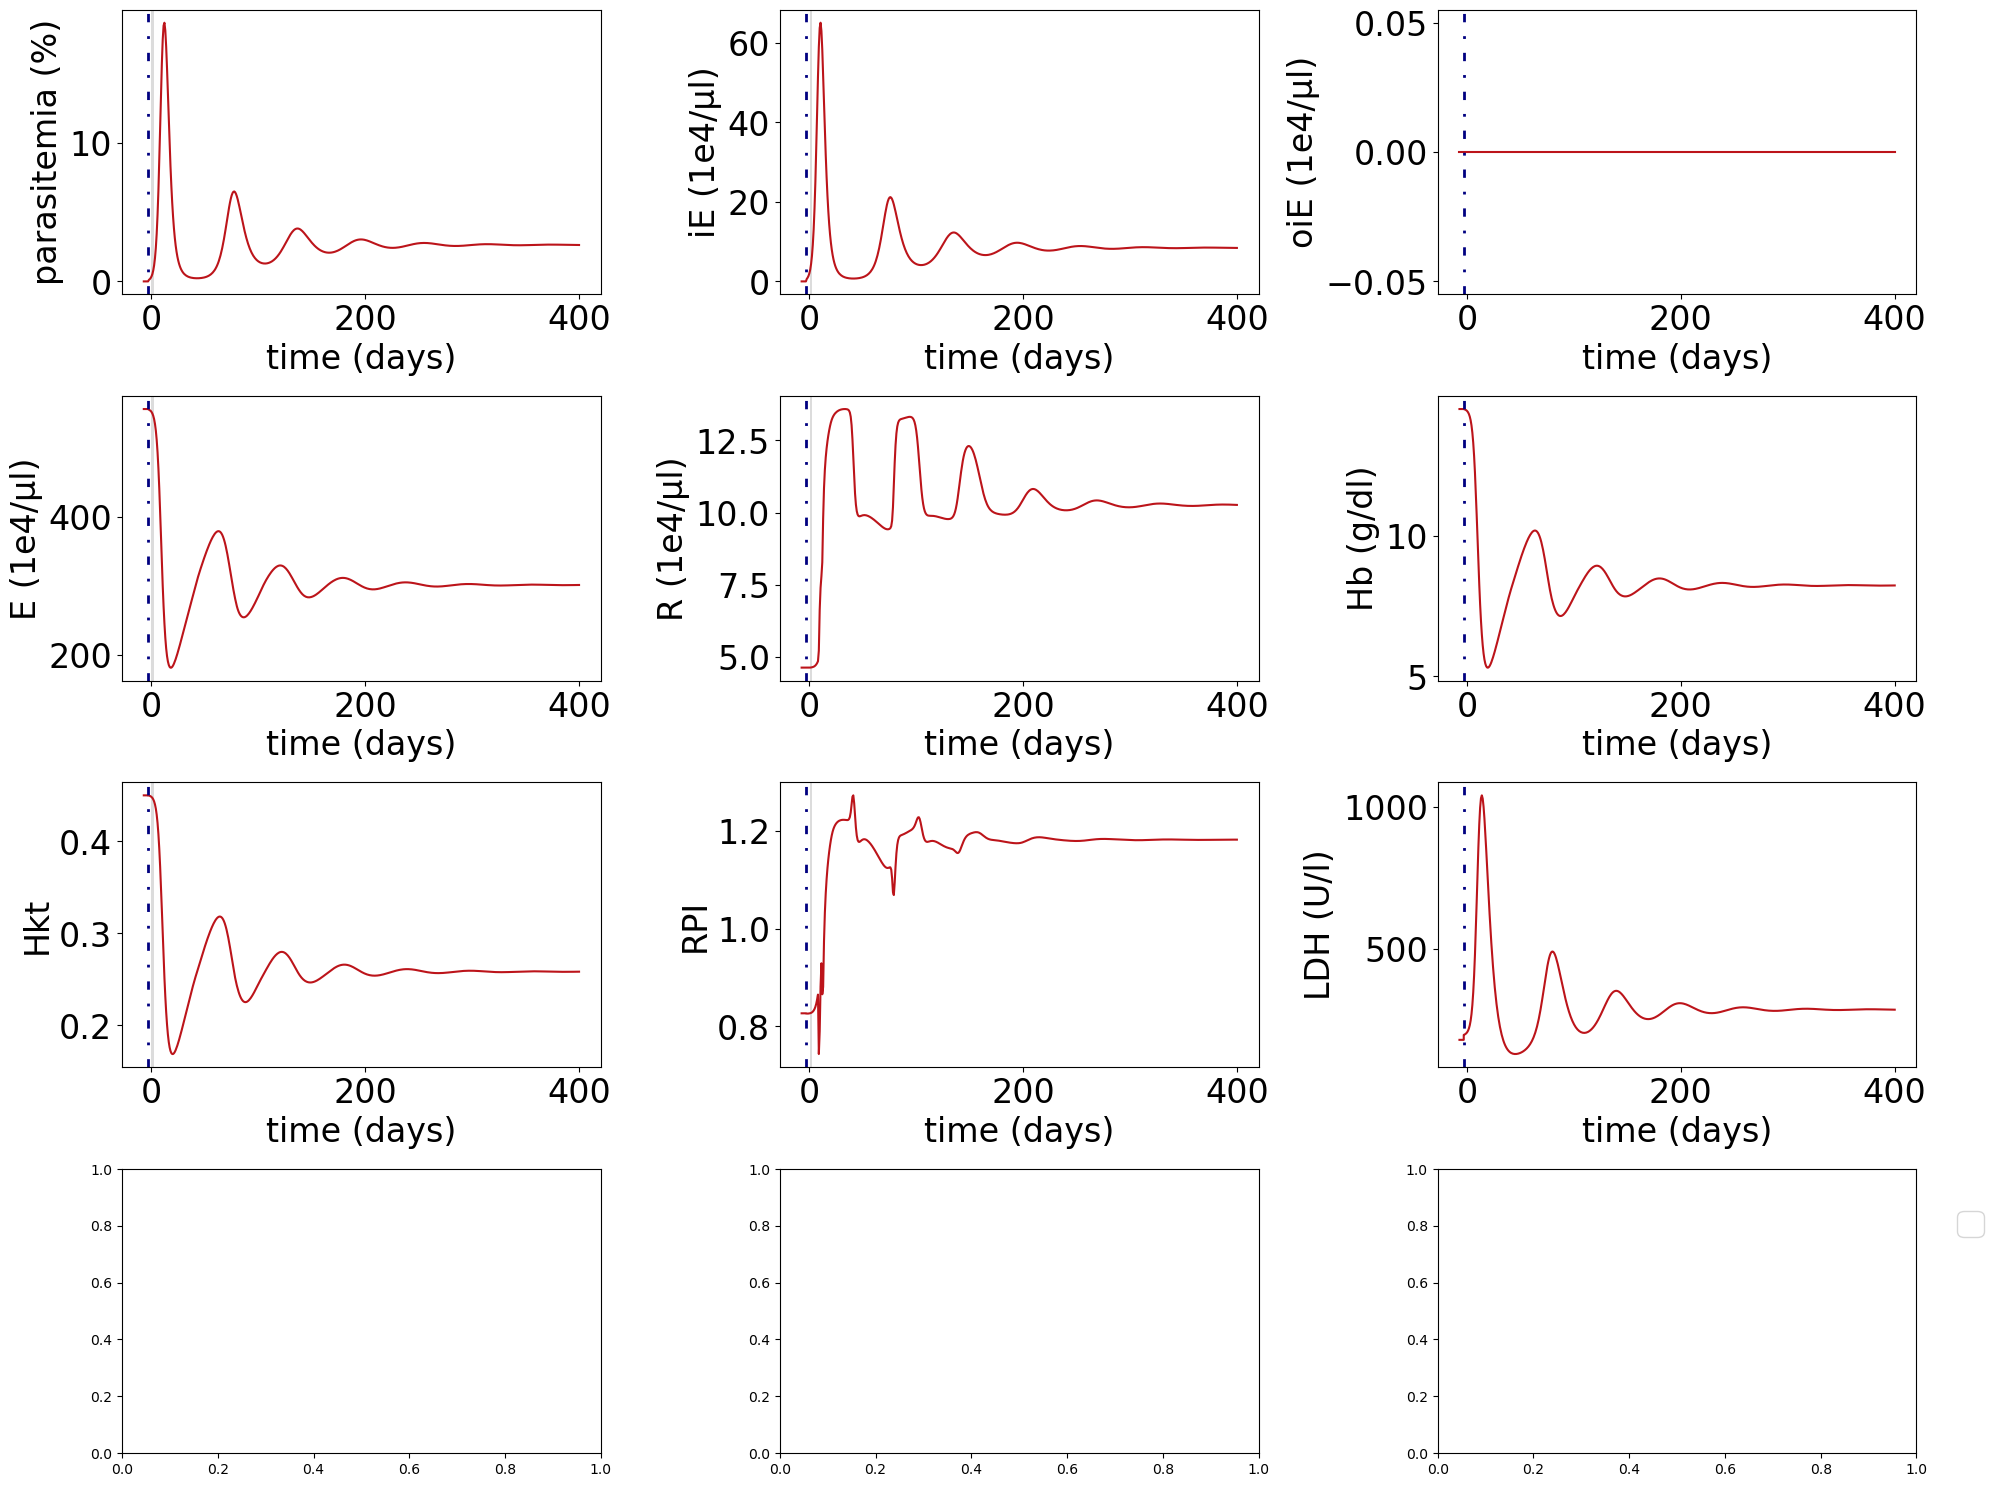

In [18]:

# simulate no by-stander haemolysis
update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 1,#4.429542038768788,
        'k_M_death': 96,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "s_BH": 9.999999922941987e-09,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
pre_t = 3.0

no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 400)

cols = 3
rows = 4  
fig, axs_all = plt.subplots(rows,cols, figsize=(20,15), sharex=True)
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
pretty_plot(no_meds, axs_all)
'''for k in range(4.1,4.2,1):
        update_parameters['tropism']=k
        no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 400)
        pretty_plot(no_meds, axs_all)'''
fig.tight_layout()
fig.show()

### Plot Erythropoiesis
Reduce Erythrocytes by 10% and hope they recover

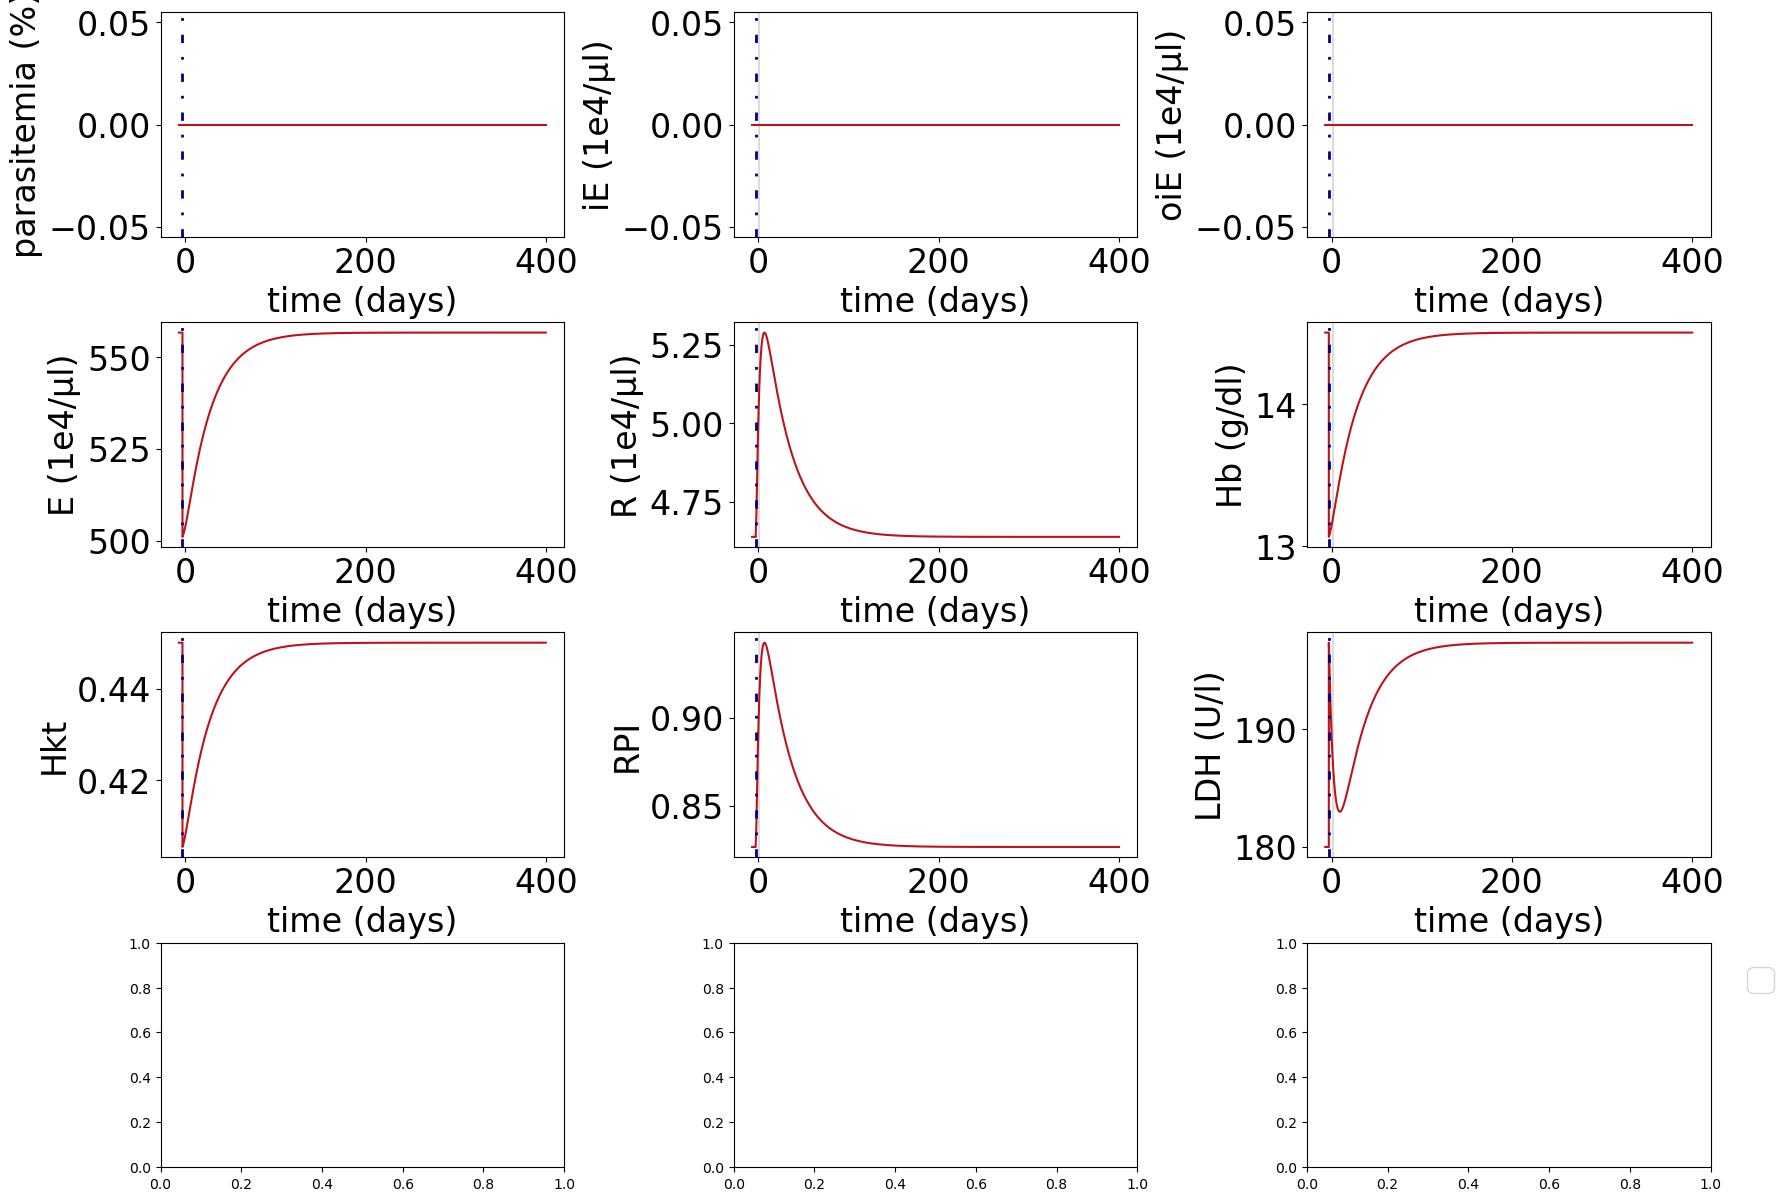

In [19]:
reduction = 0.9
# simulate no by-stander haemolysis
update_parameters= {
        "E": 5567010.309277952 * reduction,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 0,
        "tropism": 1,#4.429542038768788,
        'k_M_death': 96,
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "s_BH": 9.999999922941987e-09,
        "LDH": 197.37366622040253
}
infect_pars = update_parameters
pre_t = 3.0

no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 400)

cols = 3
rows = 4  
fig, axs_all = plt.subplots(rows,cols, figsize=(20,15))
fig.subplots_adjust(hspace=0.38, wspace= 0.42)
size_of_font = 24
pretty_plot(no_meds, axs_all)
'''for k in range(4.1,4.2,1):
        update_parameters['tropism']=k
        no_meds = simulate_model(infection_pars=infect_pars, bool_med=False, simulation_end= 400)
        pretty_plot(no_meds, axs_all)'''
fig.show()

## Figure 2 Parameter scan

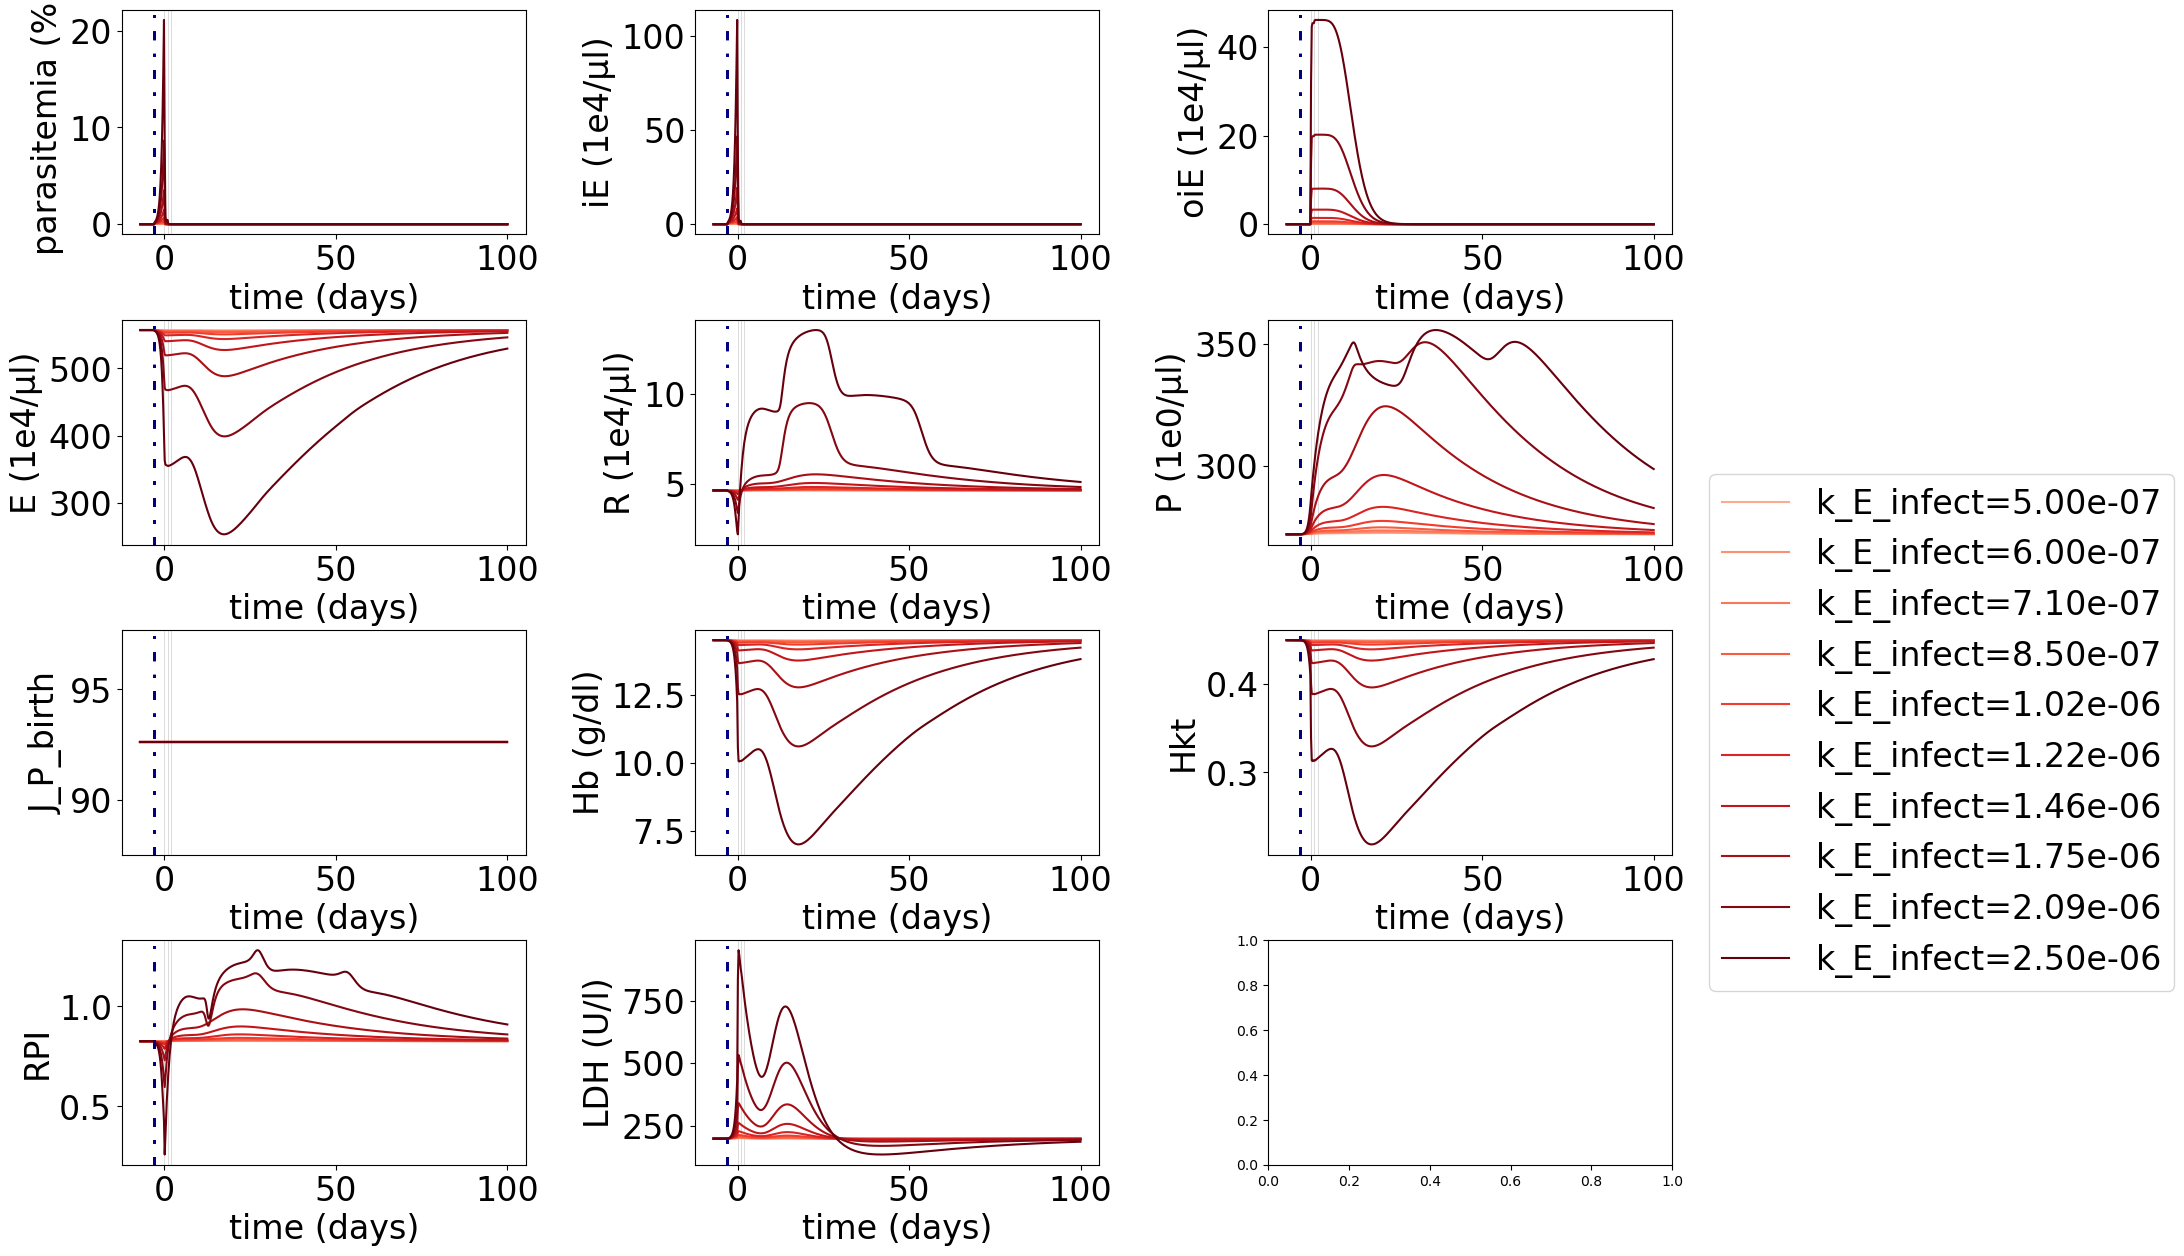

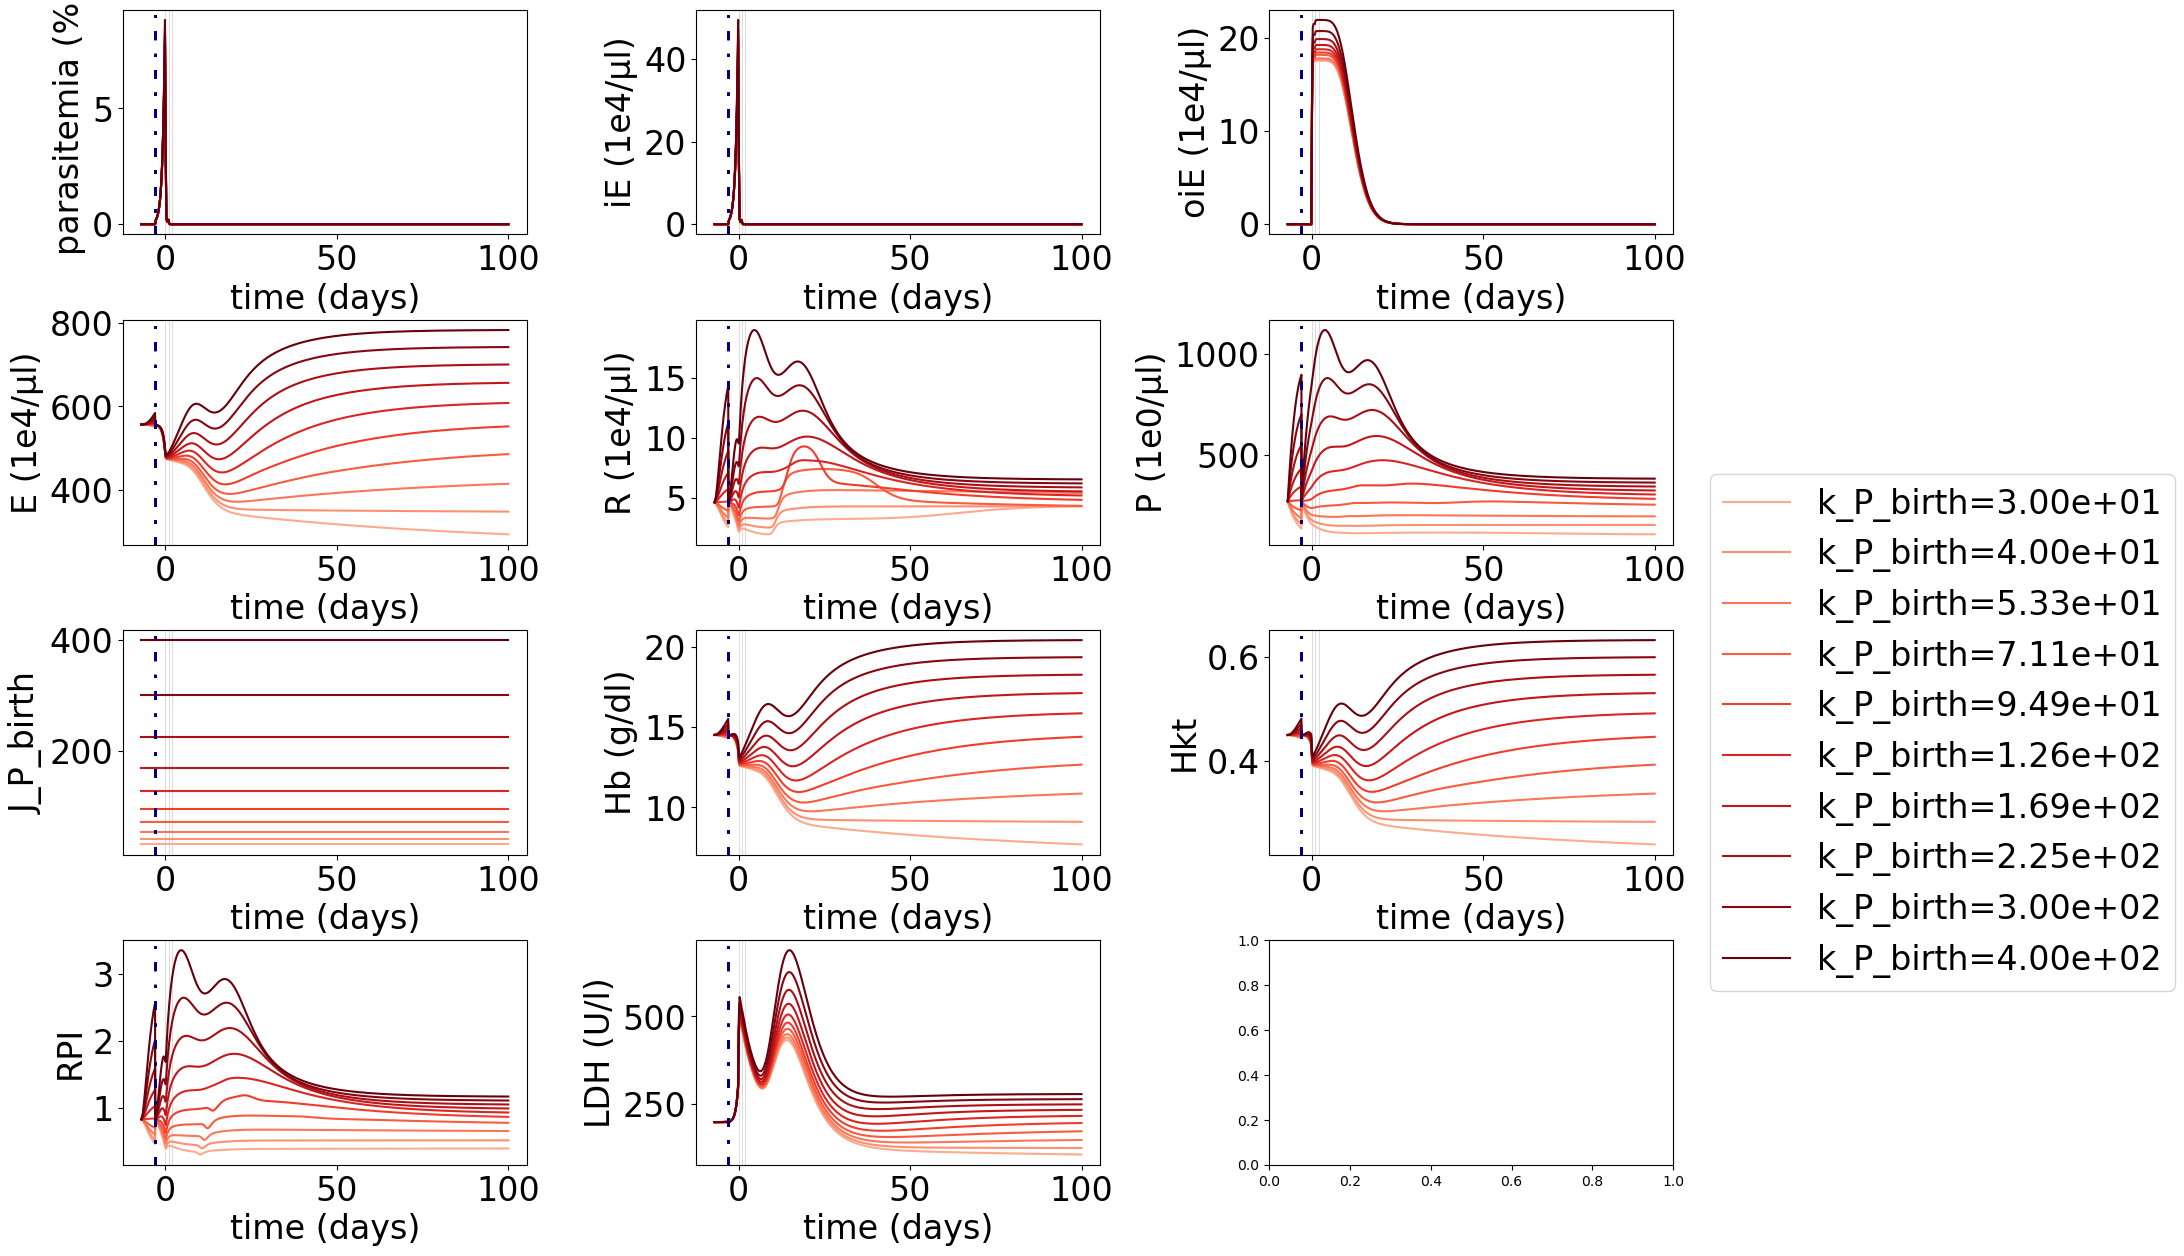

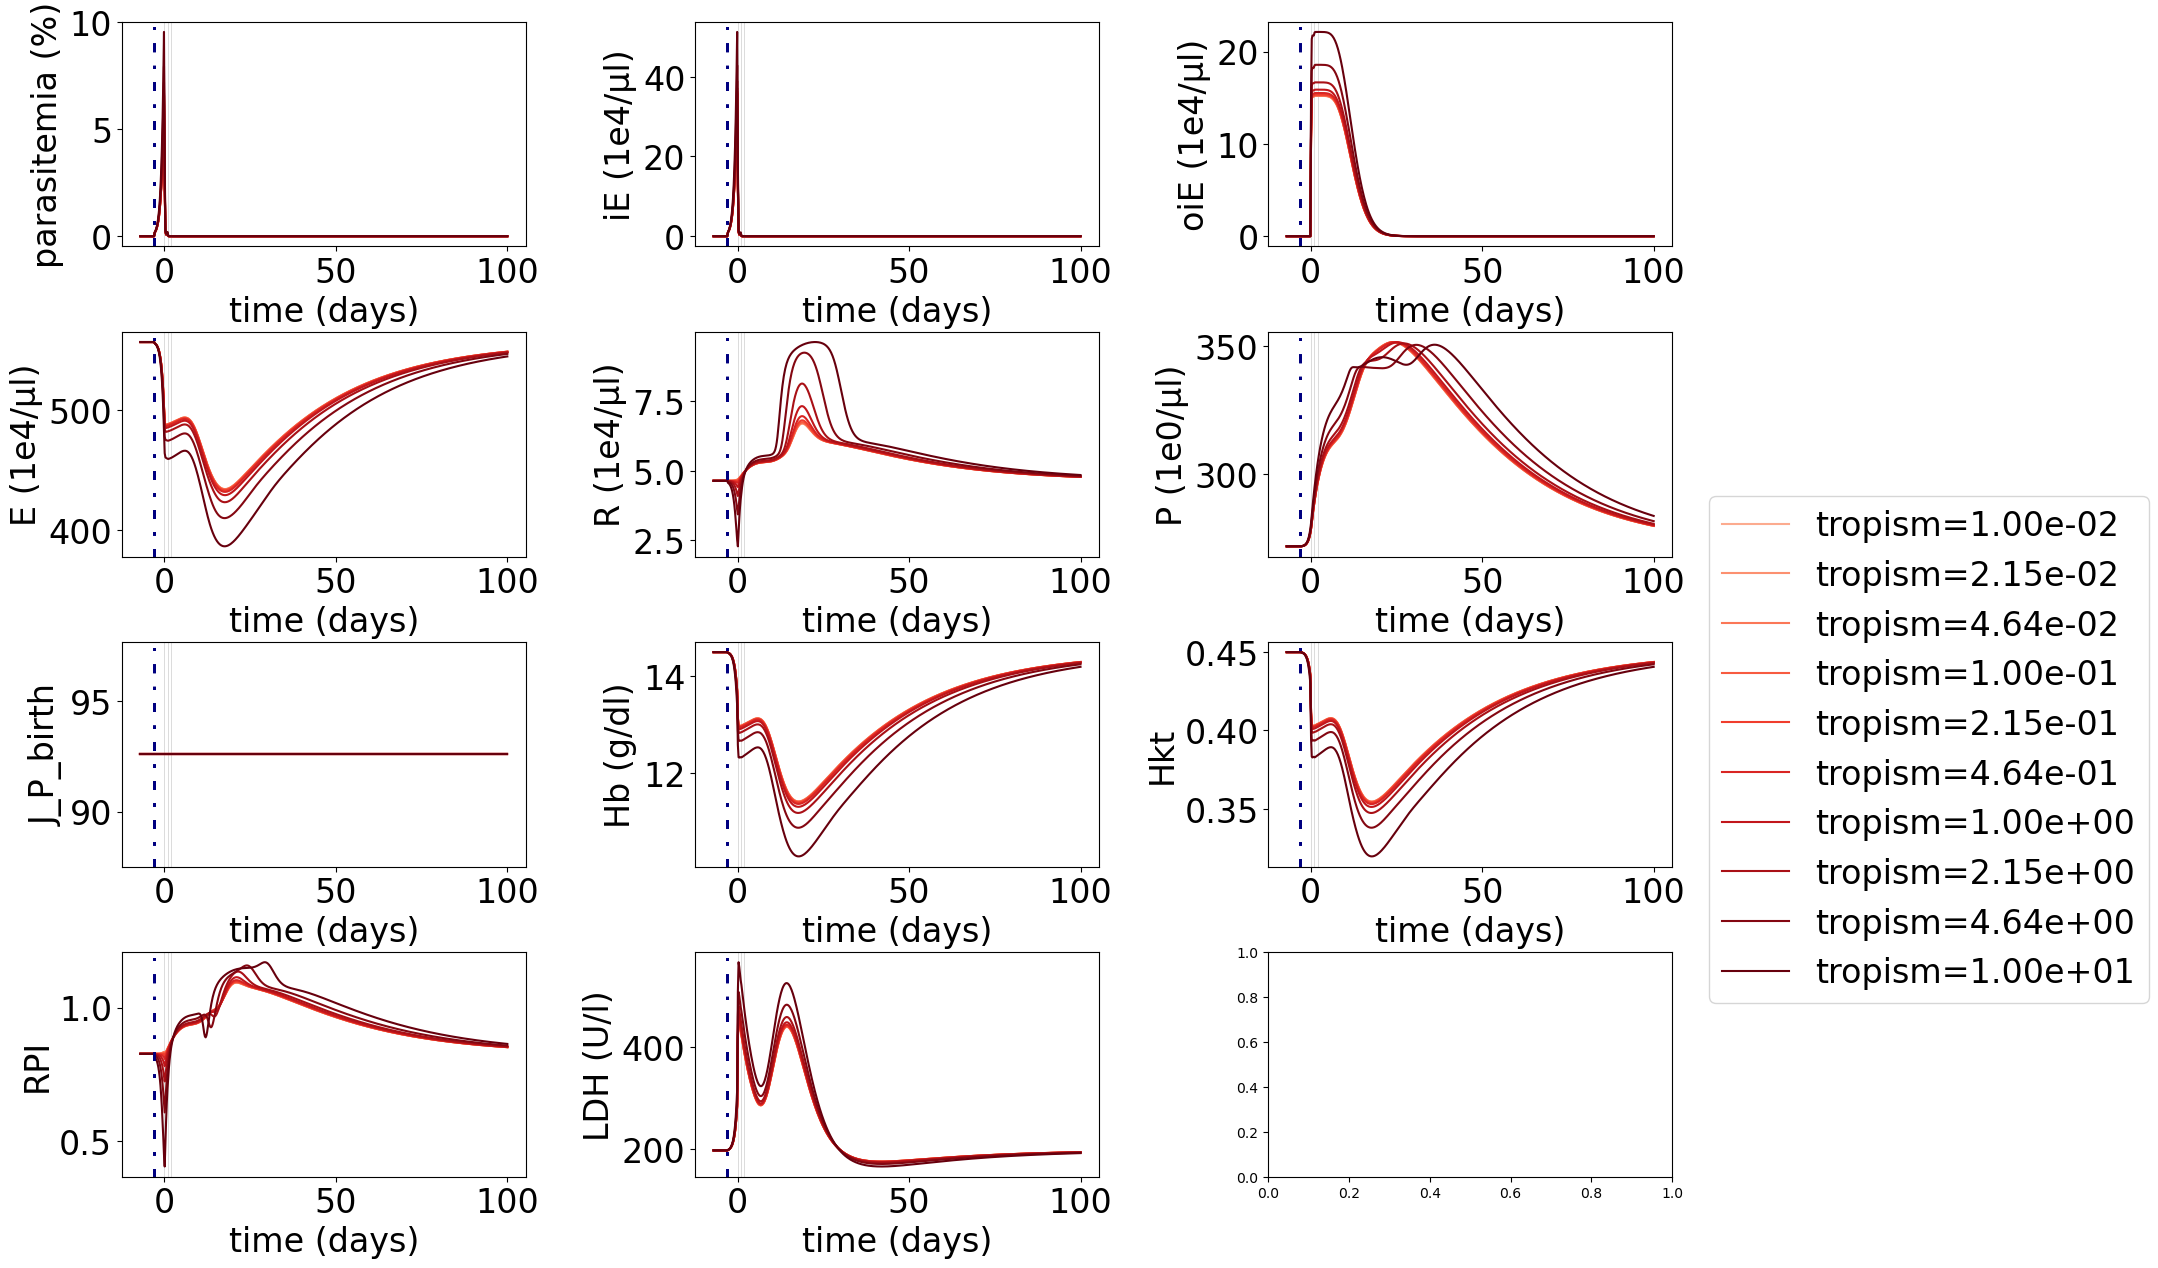

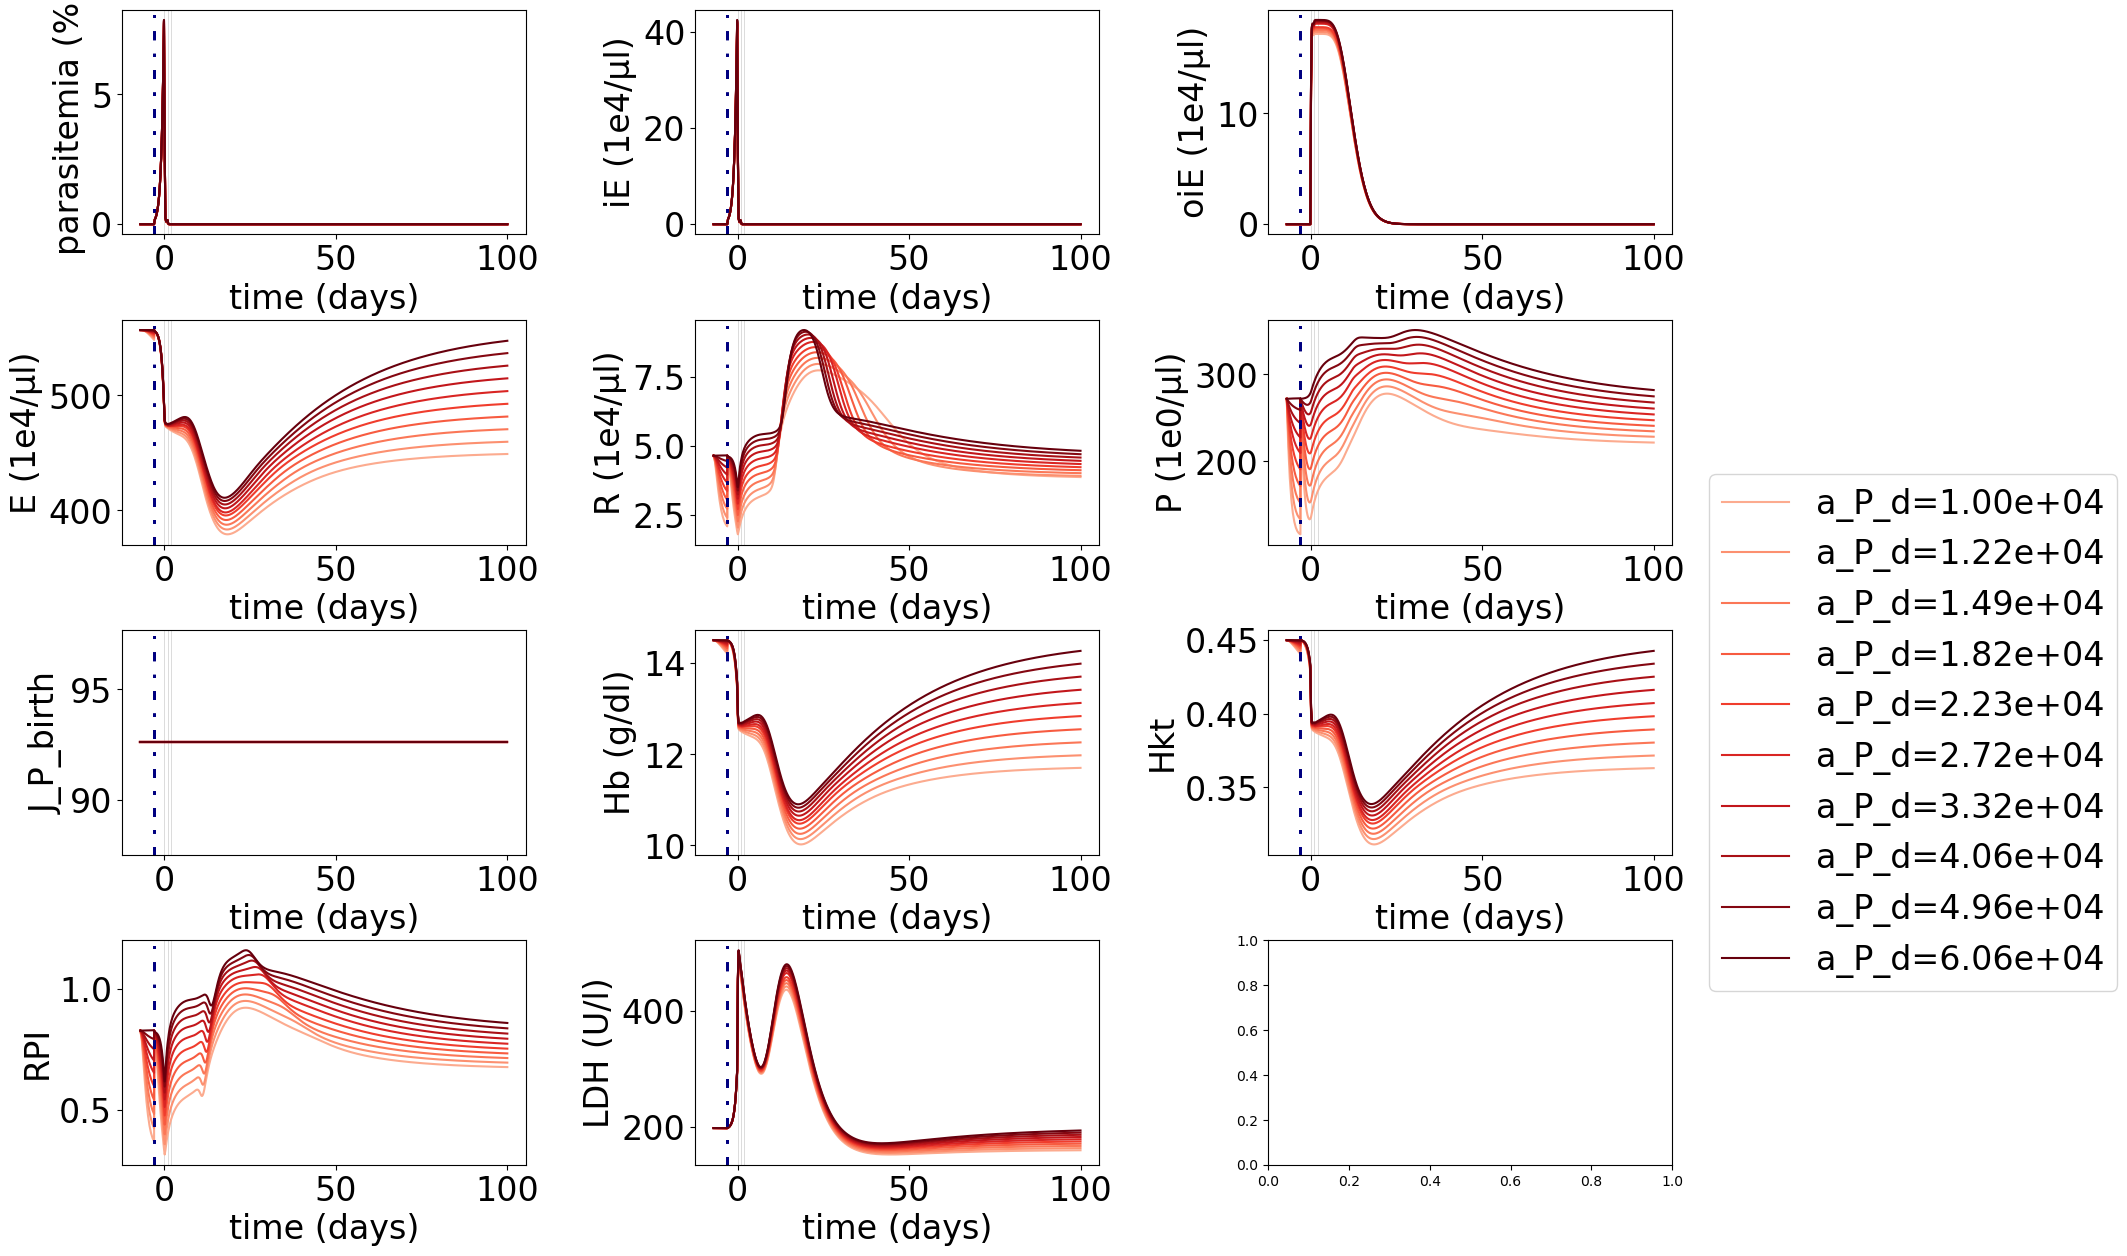

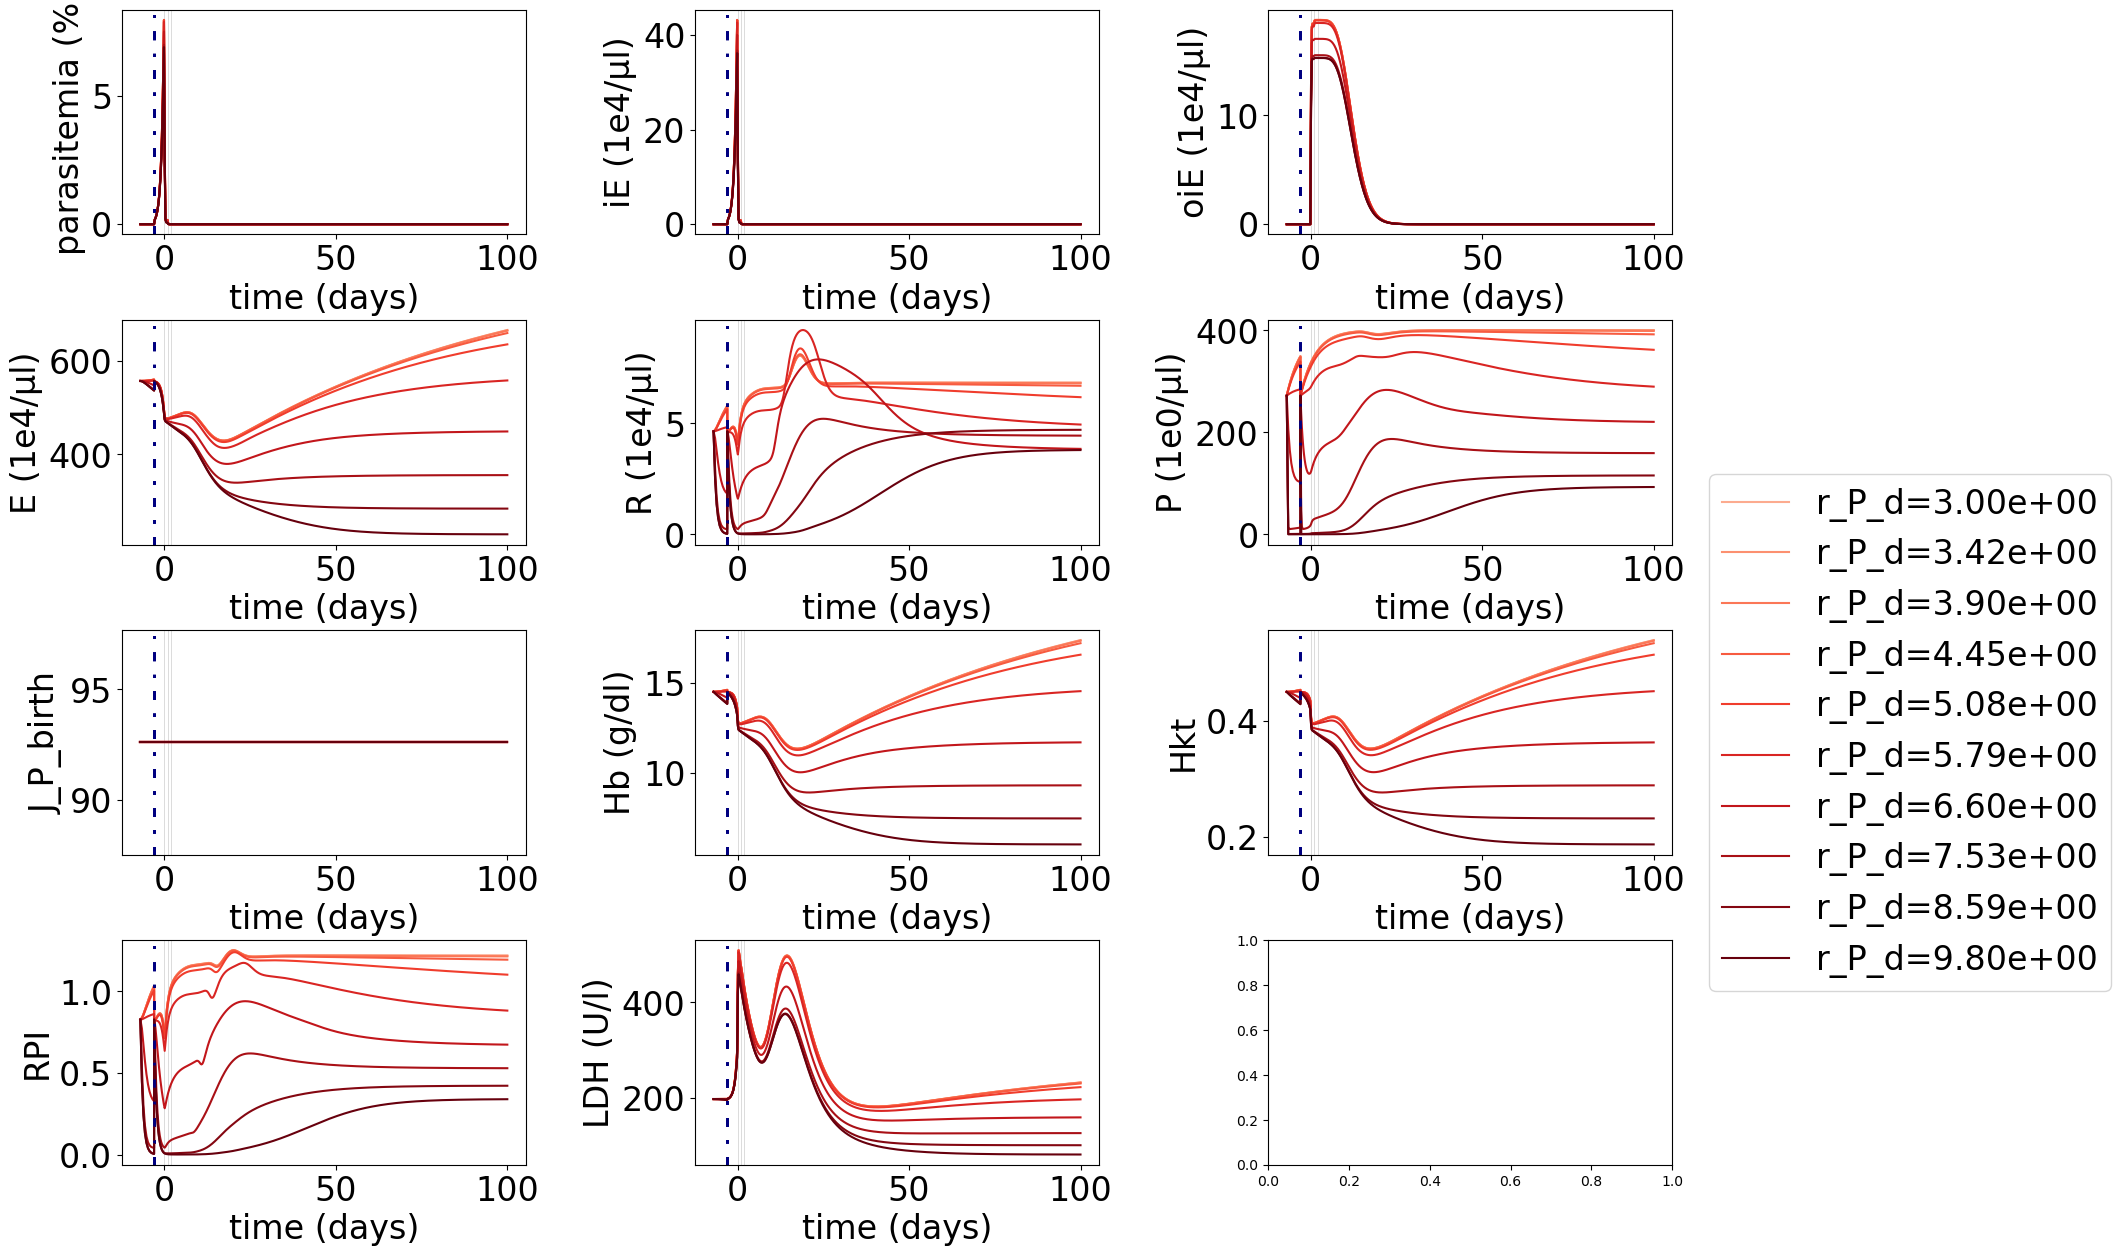

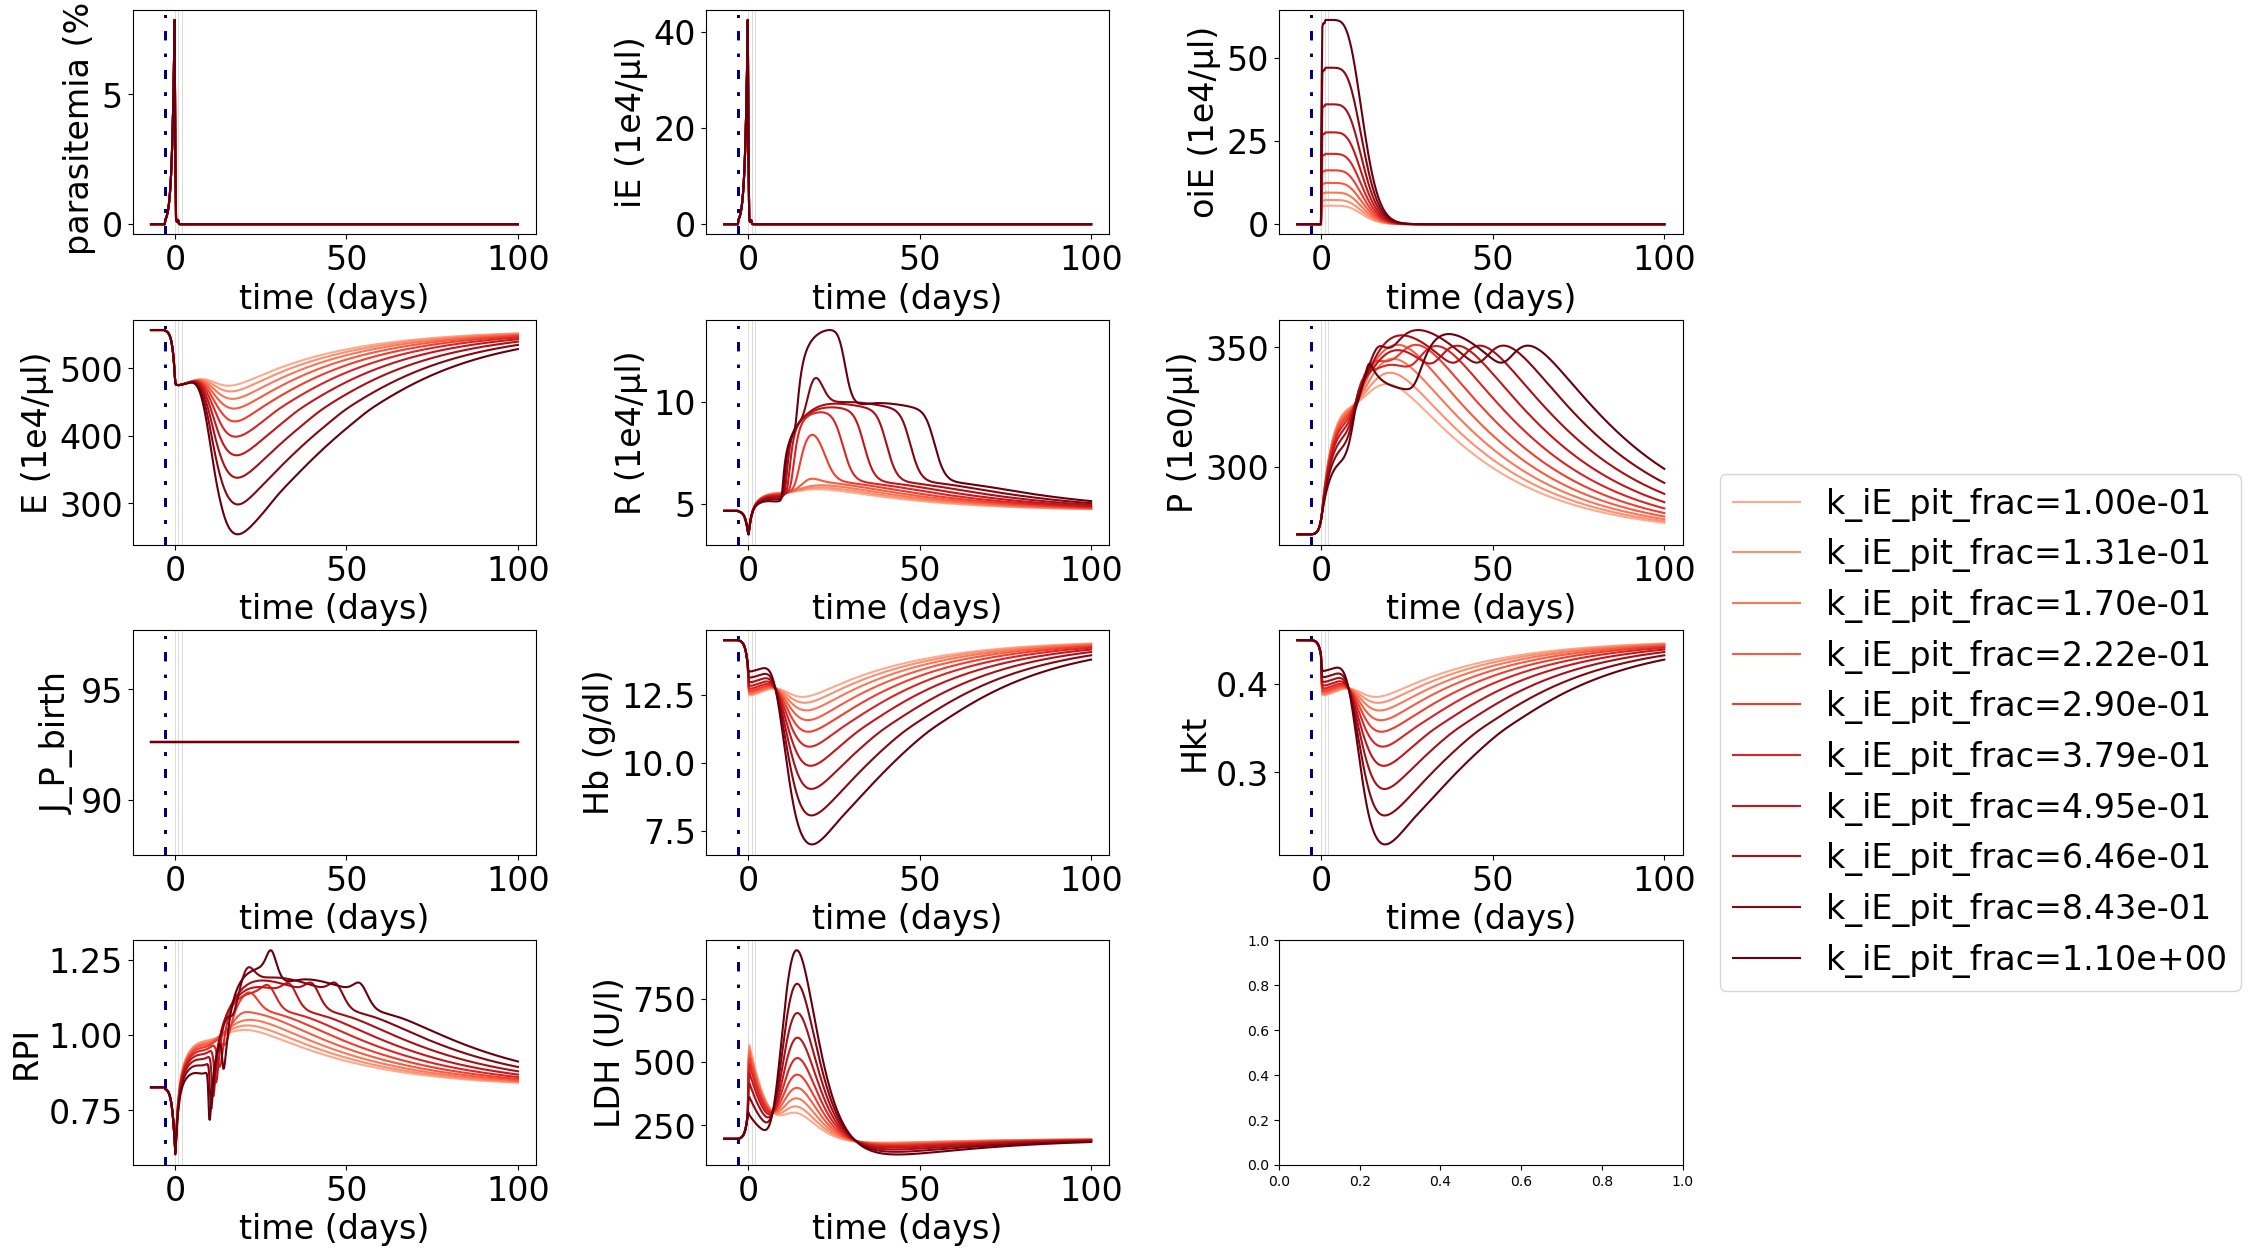

In [20]:
species_to_analyze = OrderedDict({
    'parasitemia' : ['parasitemia (%)', 1],
    '[iE]': ['iE (1e4/µl)', 1e4],
    'oiE': ['oiE (1e4/µl)', 1e4],
    '[E]': ['E (1e4/µl)', 1e4],
    '[R]': ['R (1e4/µl)', 1e4],
    '[P]': ['P (1e0/µl)', 1e0],
    'J_P_birth':['J_P_birth',1e0],
    'Hb': ['Hb (g/dl)', 1],
    'Hkt': ['Hkt', 1],
    'RPI': ['RPI', 1],
    'LDH': ['LDH (U/l)',1],
})
# Possible Reti parameters to manipulate
# k_P_birth 295
# Definition der Parameter-Boundaries
params_bounds = OrderedDict({
    #'s_BH': (5e-7, 5e-6),
    'k_E_infect': (5e-7, 2.5e-6),
    'k_P_birth': (3e1, 4e2),
    'tropism': (0,10),
    'a_P_d':(10000,60600),
    'r_P_d':(3,9.8),
    'k_iE_pit_frac': (0.1,1.1),
})

pre_t = 3
update_parameters= {
        "E": 5567010.309277952,
        "R": 46391.75257763841,
        "P": 271.8266752573979,
        "k_P_birth": 92.59782219413799,
        "LDH_RBC": 5.318123784272337e-10,
        "k_E_infect": 2.052041851367283e-06,
        "tropism": 4.429542038768788,
        'k_M_death': 48,
        's_BH': 1.361151210723645e-06,          # only change here 
        "a_P_d": 59999.97948625444,
        "k_P_d": 0.0010000000517527397,
        "r_P_d": 5.870264855546418,
        "LDH": 197.37366622040253
}
# Konvertiere bounds in logscale
params_bounds_log = convert_bounds_to_logscale(params_bounds)

# Anzahl der Werte pro Parameter 
num_values_per_param = 10

# Erzeugung der Wertemengen für jeden Parameter
param_values = {}
for param, bounds in params_bounds_log.items():
    param_values[param] = np.linspace(bounds[0], bounds[1], num_values_per_param)

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):
    # Durchführung des Parameter-Scans und Erstellung der Plots
    cols = 3
    rows = int(np.ceil(len(species_to_analyze)/cols))   

    fig, axs = plt.subplots(rows,cols, figsize=(20,15))
    fig.subplots_adjust(hspace=0.38, wspace= 0.42)
    size_of_font = 24
    infection_dict = update_parameters.copy()
    for idx, value in enumerate(values):

        infection_dict.update({param: 10**value})
        result = simulate_model(infection_pars=infection_dict, bool_med=True, bool_set_pars=True,
                                pre_t=pre_t, simulation_end=100, selections=['time']+list(species_to_analyze.keys()))	
        infection_dict.pop(param)
        
        # Plotting
        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3


            axs[row, col].plot(result['time'], result[specie]/species_to_analyze[specie][1], 
                               label=f'{param}={round(10**value,8):.2e}', 
                               color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            axs[row, col].axvspan(0, 0.3, facecolor='gainsboro', alpha=1, linewidth=2) #, label='ACT Administration')
            axs[row, col].axvspan(1, 1.3, facecolor='gainsboro', alpha=1, linewidth=2)
            axs[row, col].axvspan(2, 2.3, facecolor='gainsboro', alpha=1, linewidth=2)

            axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)))   
            
            
        handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots


    axs[-1, -1].legend(handles, labels, loc='lower left', 
                       bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)


#plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    plt.show()

#print(handles, labels)

#plt.savefig("plot.pdf")

### Parameterscan of all model parameters

In [21]:
model = te.loada('/home/nexia/PhD/pth_model/LCT_model/LCT_OIE.ant')

params_lst = ['t_mat_P',        # medicine fact
              't_R_a_init',     # calculated
              'scale_rpi',      # own idea
              'slope_rpi',      # own idea
              'Hkt_init',       # guess
              #'step_1',        # medicine fact
              #'step_2',        # medicine fact
              #'step_3',        # medicine fact
              #'t_P_a_init',    # SS calc
              'k_P_birth',      # SS calc
              #'LDH_RBC',       # calculated in Model
              #'Vol_blood',     # medicine fact
              't_E_death',      # medicine fact
              #'Vol_E',         # medicine fact
              #'Vol_R',         # medicine fact
              'k_oiE_death',    # fit from linear chain trick
              'a_P_d',          # paper value
              'k_P_d',          # paper value
              #'r_P_d',          # paper value
              's_BH',           # guess
              'tropism',        # paper values between 2-10
              'k_E_infect',     # guess
              'k_iE_death_0',   # guess
              'k_iE_pit_frac',  # guess
              'k_iE_art_max',   # guess
              'h_art',          # guess
              'ID50',           # guess but depends on person weight and such
              't_iE_rupture',   # medicine fact =2 days as rupure time for iE 
              'k_M_death',      # paper value 48 /day
              't_halb_ART_decay', # paper value 1-2 h
              'k_iE_pit_0',     # guess
              't_halb_LDH_decay',# medicine values 3-5 days
              #'N_A',           # constant
              #'Vol_iE',        # medicine fact 80fl
              #'Vol_oiE',       # medicine guess 50fl
              #'Hb_conc_R',      # paper value
              #'Hb_conc_E',      # paper value
              #'Hb_conc_iE',     # guess ~ 65%
              #'Hb_conc_oiE',    # guess similar to ring stage infected
              #'s_P_d',         # fitted linear BH idea
              #'k_P_d0',        # fitted linear BH idea
              #'t_R_a_max',     # not used, for maturation time of P & R
              #'s_R_a',         # not used, for maturation time
              #'Hkt_0',         # not used, for maturation time
              #'t_ART_add',      # set, time of ART administration
              #'k_R_death',     # calculated in model 
              #'t_P_aging',     # calculated in model
              #'rpi_step_func', # calculated in model
              #'k_iE_death',    # calculated in model
              #'k_iE_pit',      # calculated in model
              #'Vol_plasma',    # medicine fact
            ]
param_values = {}

for para in params_lst:
  val_model = model.getValue(para)
  # Erzeugung der Wertemengen für jeden Parameter
  param_values[para] = np.linspace(0.8*val_model, 10*val_model, 10)    

# Farbübergang
cmap = plt.colormaps.get_cmap('Reds')
color_start = 0.3

for i, (param, values) in enumerate(param_values.items()):
    # Durchführung des Parameter-Scans und Erstellung der Plots
    cols = 3
    rows = int(np.ceil(len(species_to_analyze)/cols))   

    fig, axs = plt.subplots(rows,cols, figsize=(20,15))
    fig.subplots_adjust(hspace=0.38, wspace= 0.42)
    size_of_font = 24
    infection_dict = update_parameters.copy()
    print(param)
    for idx, value in enumerate(values):

        infection_dict.update({param: value})
        try:
          result = simulate_model(infection_pars=infection_dict, bool_med=True, bool_set_pars=True,
                                  pre_t=pre_t, simulation_end=100, selections=['time']+list(species_to_analyze.keys()))	
        except:
           continue
        infection_dict.pop(param)
        
        # Plotting
        for j, specie in enumerate (species_to_analyze.keys()):

            row = j //3
            col = j % 3


            axs[row, col].plot(result['time'], result[specie]/species_to_analyze[specie][1], 
                              label=f'{param}={round(value,8):.2e}', 
                              color=cmap(color_start + idx * (00.8 / num_values_per_param)))
            axs[row, col].set_xlabel('time (days)',fontsize= size_of_font)
            axs[row, col].set_ylabel(species_to_analyze[specie][0],fontsize= size_of_font)
            axs[row, col].tick_params(labelsize=size_of_font)

            axs[row, col].axvspan(0, 0.3, facecolor='gainsboro', alpha=1, linewidth=2) #, label='ACT Administration')
            axs[row, col].axvspan(1, 1.3, facecolor='gainsboro', alpha=1, linewidth=2)
            axs[row, col].axvspan(2, 2.3, facecolor='gainsboro', alpha=1, linewidth=2)

            axs[row, col].axvline(-pre_t, color='navy', alpha=1, linewidth=2, linestyle=(0, (3, 5, 1, 5)))   
            
            
        handles, labels = axs[row, col].get_legend_handles_labels()  # Legend Box outsides Subplots

    axs[-1, -1].legend(handles, labels, loc='lower left', 
                      bbox_to_anchor=(1.05, 0.7),fontsize= size_of_font) #bbox (nach rechts-links, oben-unten, negativ yes)

#plt.savefig("./figures/paramscan_BHmax_short.pdf", format="pdf",bbox_inches='tight')
    plt.show()

#print(handles, labels)

#plt.savefig("plot.pdf")